In [33]:
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

seed = 10000
np.random.seed(seed)
attack_proportion = [0.8]

dataset = "synthetic"
loaded_results = np.load(f"/home/zhengyihao/TabularMark/datasets/synthetic_dataset/watermarked/{dataset}-{seed}.npy", allow_pickle=True).item()
watermarked_data = loaded_results['watermarked_data']
# watermarked_data = origin
divide_seeds = loaded_results['divide_seeds']
indices = loaded_results['indices']

sigma = 20
attack_range = 2 *sigma

for proportion in attack_proportion:
    for i in range(30):
        temp = watermarked_data.copy()
        indices = np.random.choice(len(temp), size=int(proportion * len(temp)), replace=False)
        perturb_values = np.random.uniform(-attack_range, attack_range, size=len(indices))
        temp.loc[indices, 'dimension_0'] += perturb_values
        temp.to_csv(f"/home/zhengyihao/TabularMark/datasets/synthetic_dataset/ROC/{dataset}-{seed}-{proportion}-{i}.csv", index=False)


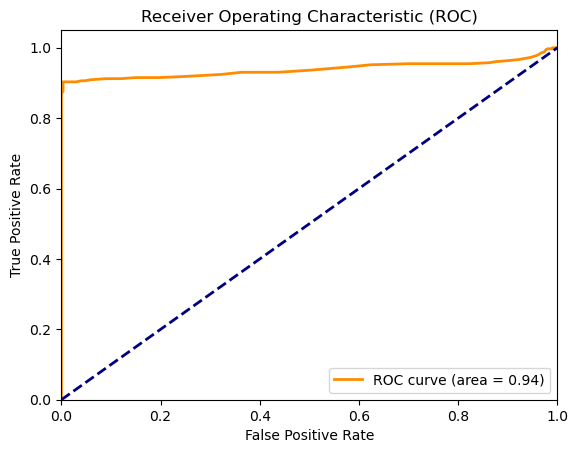

In [34]:
import pandas as pd
import numpy as np
import os
import math
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def calculate_z_score(watermarked_data, origin, indices, divide_seeds, p, k, n):
    green_cell = 0
    for idx, divide_seed in zip(indices, divide_seeds):
        np.random.seed(divide_seed)
        # 生成等分点
        intervals = np.linspace(-p, p, k + 1)
        # 将 [-p, p] 等分为 k 份
        segments = [(intervals[i], intervals[i + 1]) for i in range(k)]
        np.random.shuffle(segments)
        # 将 segments 分为 green domains 和 red domains
        half_k = k // 2
        green_domains = segments[:half_k]
        red_domains = segments[half_k:]

        difference = watermarked_data.loc[idx, 'dimension_0'] - origin.loc[idx, 'dimension_0']
        for low, high in green_domains:
            if low <= difference < high:
                green_cell += 1
                break

    z_score = (green_cell - n/2) / math.sqrt(n/4)
    return z_score

# 加载原始数据
original_file = '/home/zhengyihao/TabularMark/datasets/synthetic_dataset/synthetic_data.csv'
origin = pd.read_csv(original_file)

# 定义路径
dataset = "synthetic"
seed = 10000
roc_path = '/home/zhengyihao/TabularMark/datasets/synthetic_dataset/ROC/'
watermarked_path = '/home/zhengyihao/TabularMark/datasets/synthetic_dataset/watermarked/'

# 参数
sigma = 20
p = 2 * sigma
k = 500
n = 300

# 计算所有水印数据集的 z-score
z_scores = []
true_labels = []

for file in os.listdir(roc_path):
    if file.endswith('.csv'):
        # print(file)
        proportion = float(file.split('-')[2])  # 假设文件名中包含 proportion 信息
        loaded_results = np.load(os.path.join(watermarked_path, f"{dataset}-{seed}.npy"), allow_pickle=True).item()
        watermarked_data = pd.read_csv(os.path.join(roc_path, file))
        divide_seeds = loaded_results['divide_seeds']
        indices = loaded_results['indices']

        z_score = calculate_z_score(watermarked_data, origin, indices, divide_seeds, p, k, n)
        z_scores.append(z_score)
        true_labels.append(1)  # 设定 true_label，如果 z_score > 0 认为有水印，否则无水印

perturb_path = '/home/zhengyihao/TabularMark/datasets/synthetic_dataset/perturbed/'
for file in os.listdir(perturb_path):
    if file.endswith('.csv'):
        # print(file)
        proportion = float(file.split('-')[2])  # 假设文件名中包含 proportion 信息
        loaded_results = np.load(os.path.join(watermarked_path, f"{dataset}-{seed}.npy"), allow_pickle=True).item()
        watermarked_data = pd.read_csv(os.path.join(perturb_path, file))
        divide_seeds = loaded_results['divide_seeds']
        indices = loaded_results['indices']

        z_score = calculate_z_score(watermarked_data, origin, indices, divide_seeds, p, k, n)
        # print(z_score)
        z_scores.append(z_score)
        true_labels.append(0)  # 设定 true_label，如果 z_score > 0 认为有水印，否则无水印

# print(z_scores)
# print(true_labels)
# 比较 z-score 和阈值，记录真实正例和假正例
fpr, tpr, _ = roc_curve(true_labels, z_scores)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# case 1
# perturbed 0.2 0.4 0.6 * 100
# ROC 0.2 0.4 0.6 * 100 0.8 * 50
# ROC curve (area = 0.94)
